In [64]:
# %pip install git+https://github.com/tensorflow/docs

import requests
import os.path
import asyncio
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from riotwatcher import TftWatcher, ApiError

from utils.configuration import settings
from utils.utils import *
from tft.api import *

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(10, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)
%config InlineBackend.figure_format = 'retina'


In [65]:
API_KEY = settings.api_key
ASSETS_DIR = settings.assets_dir
SERVER = 'na1'  # euw1 na1 kr oc1
LEAGUE='challengers'
MAX_COUNT = settings.max_count
LATEST_RELEASE = '12.12.450.4196'

TARGETNAME = 'placement'

In [66]:
raw_df = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_matches.pickle'))

In [67]:
raw_df

,match_id,placement,augment0,augment1,augment2,Set7_Bard,Set7_Bruiser,Set7_Cavalier,Set7_Dragon,Set7_Dragonmancer,...,TFT7_Aatrox_item1,TFT7_Vladimir_item1,TFT7_Vladimir_item2,TFT7_Thresh_item2,TFT7_Senna_item0,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Skarner_item1,TFT7_Skarner_item2,TFT7_Aatrox_item2
0,NA1_4353652791,1,TFT6_Augment_Weakspot,TFT6_Augment_Electrocharge2,TFT6_Augment_ComponentGrabBag,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NA1_4353652791,8,TFT6_Augment_CelestialBlessing1,TFT6_Augment_SecondWind2,TFT7_Augment_RevelPartyFavors,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NA1_4353652791,4,TFT7_Augment_BruiserTrait,TFT6_Augment_SecondWind2,TFT6_Augment_TomeOfTraits1,NaN,2.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NA1_4353652791,3,TFT7_Augment_RagewingTrait,TFT6_Augment_TargetDummies,TFT6_Augment_CelestialBlessing2,NaN,0.0,0.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NA1_4353652791,7,TFT6_Augment_TriForce1,TFT6_Augment_Meditation2,TFT7_Augment_TempestEyeOfTheStorm,NaN,0.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7603,NA1_4355169385,8,TFT6_Augment_Weakspot,TFT7_Augment_SwiftshotPressTheAttack,TFT7_Augment_UrfsGrabBag1,NaN,1.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7604,NA1_4355169385,6,TFT7_Augment_GuildTrait,TFT6_Augment_Ascension,TFT7_Augment_CavalierEmblem,NaN,1.0,1.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7605,NA1_4355169385,5,TFT6_Augment_ItemGrabBag1,TFT6_Augment_SunfireBoard,TFT6_Augment_Ascension,1.0,1.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7606,NA1_4355169385,4,TFT6_Augment_Weakspot,TFT6_Augment_Meditation2,TFT6_Augment_SalvageBin,NaN,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [69]:
raw_df = reduce_mem_usage(raw_df)

Mem. usage decreased to 12.92 Mb (16.6% reduction)


In [70]:
raw_df[raw_df['match_id'].duplicated()]

,match_id,placement,augment0,augment1,augment2,Set7_Bard,Set7_Bruiser,Set7_Cavalier,Set7_Dragon,Set7_Dragonmancer,...,TFT7_Aatrox_item1,TFT7_Vladimir_item1,TFT7_Vladimir_item2,TFT7_Thresh_item2,TFT7_Senna_item0,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Skarner_item1,TFT7_Skarner_item2,TFT7_Aatrox_item2
1,NA1_4353652791,8,TFT6_Augment_CelestialBlessing1,TFT6_Augment_SecondWind2,TFT7_Augment_RevelPartyFavors,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NA1_4353652791,4,TFT7_Augment_BruiserTrait,TFT6_Augment_SecondWind2,TFT6_Augment_TomeOfTraits1,NaN,2.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NA1_4353652791,3,TFT7_Augment_RagewingTrait,TFT6_Augment_TargetDummies,TFT6_Augment_CelestialBlessing2,NaN,0.0,0.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NA1_4353652791,7,TFT6_Augment_TriForce1,TFT6_Augment_Meditation2,TFT7_Augment_TempestEyeOfTheStorm,NaN,0.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NA1_4353652791,5,TFT6_Augment_TinyTitans,TFT6_Augment_TomeOfTraits1,TFT6_Augment_ComponentGrabBag,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7603,NA1_4355169385,8,TFT6_Augment_Weakspot,TFT7_Augment_SwiftshotPressTheAttack,TFT7_Augment_UrfsGrabBag1,NaN,1.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7604,NA1_4355169385,6,TFT7_Augment_GuildTrait,TFT6_Augment_Ascension,TFT7_Augment_CavalierEmblem,NaN,1.0,1.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7605,NA1_4355169385,5,TFT6_Augment_ItemGrabBag1,TFT6_Augment_SunfireBoard,TFT6_Augment_Ascension,1.0,1.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7606,NA1_4355169385,4,TFT6_Augment_Weakspot,TFT6_Augment_Meditation2,TFT6_Augment_SalvageBin,NaN,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
def check_NA(df):
    missing_val = df.isnull().sum()
    print(missing_val[missing_val > 0])

In [72]:
# Check NA
check_NA(raw_df)

augment1                 3
augment2                27
Set7_Bard             5390
Set7_Bruiser          3110
Set7_Cavalier         4935
                      ... 
TFT7_Senna_item1      7589
TFT7_Senna_item2      7598
TFT7_Skarner_item1    7595
TFT7_Skarner_item2    7603
TFT7_Aatrox_item2     7589
Length: 264, dtype: int64


In [73]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [74]:
raw_df = impute(raw_df)

In [75]:
numeric_cols = raw_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = raw_df.select_dtypes(include=['object']).columns.tolist()

In [76]:
def check_categorical_cols(df):
    print('Values along with Count in the Categorical Columns','\n')
    for i in categorical_cols:
        print(i)
        print(df[i].value_counts(),'\n')  

In [77]:
check_categorical_cols(raw_df)

Values along with Count in the Categorical Columns 

match_id
NA1_4353652791    8
NA1_4355920528    8
NA1_4355410655    8
NA1_4356194694    8
NA1_4354009163    8
                 ..
NA1_4355682630    8
NA1_4357001545    8
NA1_4354258161    8
NA1_4354763736    8
NA1_4355169385    8
Name: match_id, Length: 951, dtype: int64 

augment0
TFT6_Augment_PortableForge                359
TFT6_Augment_SecondWind2                  240
TFT7_Augment_UrfsGrabBag1                 236
TFT6_Augment_SecondWind1                  189
TFT6_Augment_Weakspot                     187
                                         ... 
TFT6_Augment_Distancing3                    2
TFT7_Augment_CavalierDevastatingCharge      1
TFT7_Augment_GuildLootHR                    1
TFT6_Augment_Diversify2                     1
TFT7_Augment_AstralTrait2                   1
Name: augment0, Length: 186, dtype: int64 

augment1
TFT6_Augment_SecondWind1                  350
TFT6_Augment_Weakspot                     311
TFT6_Augment_T

In [78]:
# raw_df.arrival_day = pd.to_numeric(raw_df.arrival_day, errors='coerce').astype('int64')
# raw_df[TARGETNAME] = raw_df[TARGETNAME].astype(bool)

In [79]:
raw_df.describe()

,placement,Set7_Bard,Set7_Bruiser,Set7_Cavalier,Set7_Dragon,Set7_Dragonmancer,Set7_Guild,Set7_Jade,Set7_Legend,Set7_Mirage,...,TFT7_Skarner,TFT7_AurelionSol,TFT7_Lillia,TFT7_Ezreal,TFT7_Varus,TFT7_DragonPurple,TFT7_Nidalee,TFT7_Elise,TFT7_Aatrox,TFT7_Senna
count,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,...,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000
mean,4.500000,0.291535,0.490405,0.286278,0.554942,0.478707,1.049290,0.450184,0.018796,0.196898,...,0.024974,0.004600,0.064143,0.078076,0.032072,0.044164,0.059674,0.064143,0.021162,0.017876
std,2.291438,0.454499,0.666115,0.662870,0.523289,0.818363,1.235007,0.749490,0.135813,0.700715,...,0.238652,0.080127,0.352403,0.414922,0.294593,0.287133,0.411627,0.361972,0.203684,0.186140
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.250000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,1.000000,4.000000,4.000000,2.000000,3.000000,6.000000,4.000000,1.000000,4.000000,...,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [80]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7608 entries, 0 to 7607
Columns: 267 entries, match_id to TFT7_Aatrox_item2
dtypes: float32(87), int8(1), object(179)
memory usage: 12.9+ MB


2022-06-29 01:51:03,121 [WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


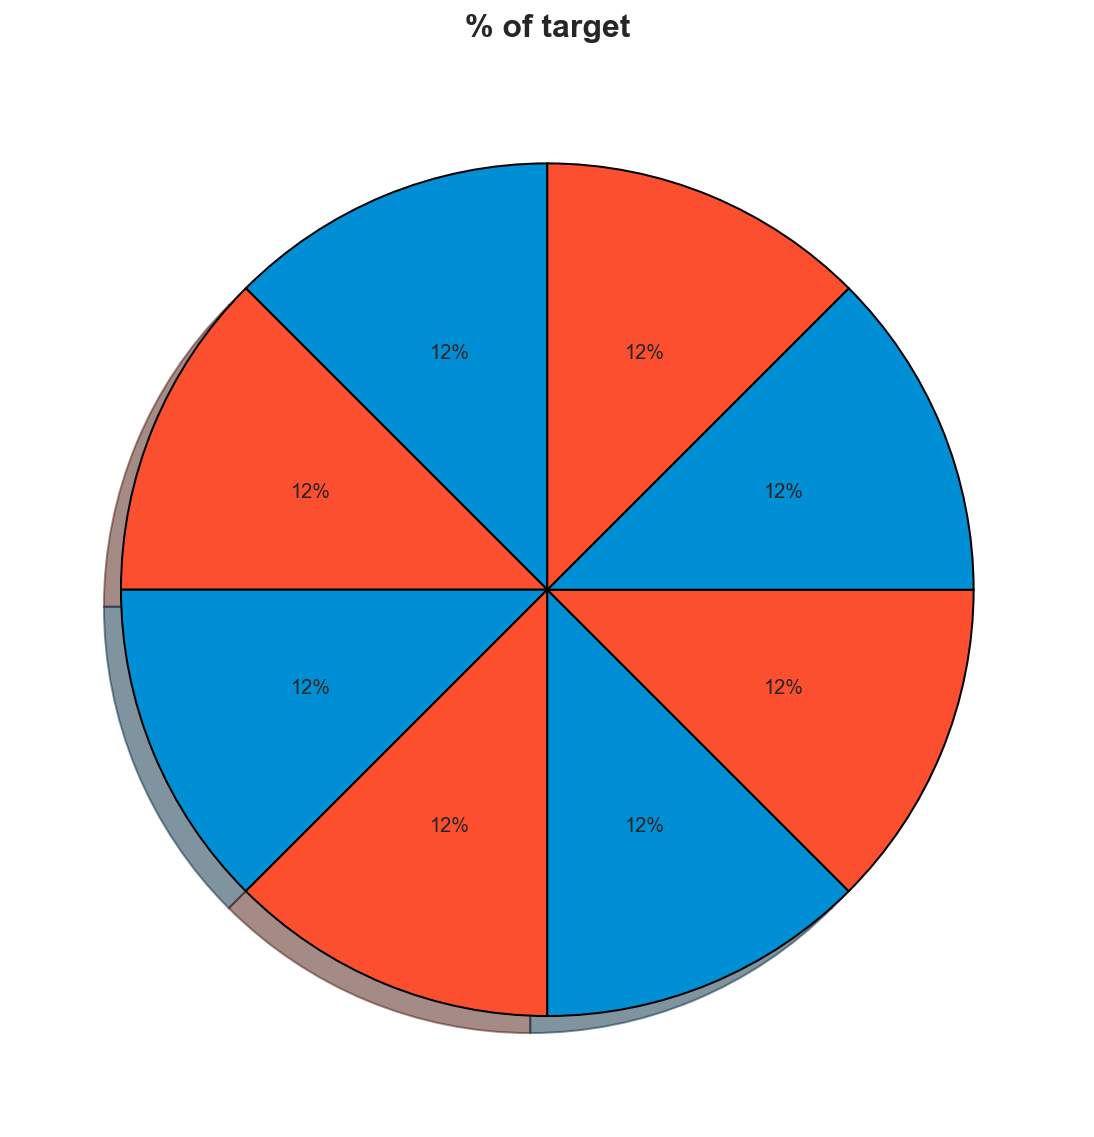

In [81]:
target_count = raw_df[TARGETNAME].value_counts().to_frame().T

colors = ['#008fd5', '#fc4f30']
plt.figure(figsize=(8,8))
plt.title('% of target')
plt.tight_layout()
plt.pie(list(target_count.iloc[0].values), startangle=90, wedgeprops={'edgecolor': 'black'}, colors=colors, autopct='%1.f%%', shadow=True)
plt.legend(loc='best', fontsize='medium')
plt.show()

In [84]:
X = raw_df.drop(['match_id'], axis=1)


In [85]:
y = X.pop(TARGETNAME)

In [86]:
matches_df = X.copy()
matches_df[TARGETNAME] = y

In [87]:
X.fillna('', inplace=True)

In [88]:
y

0       1
1       8
2       4
3       3
4       7
       ..
7603    8
7604    6
7605    5
7606    4
7607    2
Name: placement, Length: 7608, dtype: int8

In [89]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

In [90]:
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

In [91]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7608 entries, 0 to 7607
Columns: 266 entries, match_id to TFT7_Aatrox_item2
dtypes: int64(87), object(179)
memory usage: 15.4+ MB


In [92]:
X

,match_id,augment0,augment1,augment2,Set7_Bard,Set7_Bruiser,Set7_Cavalier,Set7_Dragon,Set7_Dragonmancer,Set7_Guild,...,TFT7_Aatrox_item1,TFT7_Vladimir_item1,TFT7_Vladimir_item2,TFT7_Thresh_item2,TFT7_Senna_item0,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Skarner_item1,TFT7_Skarner_item2,TFT7_Aatrox_item2
0,NA1_4353652791,TFT6_Augment_Weakspot,TFT6_Augment_Electrocharge2,TFT6_Augment_ComponentGrabBag,1,1,0,1,0,2,...,,,,,,,,,,
1,NA1_4353652791,TFT6_Augment_CelestialBlessing1,TFT6_Augment_SecondWind2,TFT7_Augment_RevelPartyFavors,1,0,0,0,0,1,...,,,,,,,,,,
2,NA1_4353652791,TFT7_Augment_BruiserTrait,TFT6_Augment_SecondWind2,TFT6_Augment_TomeOfTraits1,0,2,0,0,0,0,...,,,,,,,,,,
3,NA1_4353652791,TFT7_Augment_RagewingTrait,TFT6_Augment_TargetDummies,TFT6_Augment_CelestialBlessing2,0,0,0,0,2,0,...,,,,,,,,,,
4,NA1_4353652791,TFT6_Augment_TriForce1,TFT6_Augment_Meditation2,TFT7_Augment_TempestEyeOfTheStorm,0,0,0,0,2,0,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7603,NA1_4355169385,TFT6_Augment_Weakspot,TFT7_Augment_SwiftshotPressTheAttack,TFT7_Augment_UrfsGrabBag1,0,1,0,1,1,1,...,,,,,,,,,,
7604,NA1_4355169385,TFT7_Augment_GuildTrait,TFT6_Augment_Ascension,TFT7_Augment_CavalierEmblem,0,1,1,0,0,3,...,,,,,,,,,,
7605,NA1_4355169385,TFT6_Augment_ItemGrabBag1,TFT6_Augment_SunfireBoard,TFT6_Augment_Ascension,1,1,0,0,0,3,...,,,,,,,,,,
7606,NA1_4355169385,TFT6_Augment_Weakspot,TFT6_Augment_Meditation2,TFT6_Augment_SalvageBin,0,1,1,1,0,0,...,,,,,,,,,,


In [93]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

In [94]:
xgb = XGBRegressor(objective="reg:squarederror", eval_metric="mae",
                    n_estimators=200) #, use_label_encoder=False

In [95]:
le_target = LabelEncoder()

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
# augments_oe = OrdinalEncoder()
# room_oe = OrdinalEncoder()
preproc = StandardScaler()

# Encode label. 0 = Show , 1 = No Show
y = le_target.fit_transform(y)

In [96]:
# Encode category columns.
logistic_regression_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("one_hot_time", one_hot_encoder, categorical_cols),
        ],
        remainder=preproc,
    ),
    xgb,
)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, random_state=42)

logistic_regression_pipeline.fit(X_train, y_train)
y_pred = logistic_regression_pipeline.predict(X_test)

In [98]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis = 1 ),
        'precision': cm / cm.sum(axis = 0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout = True, figsize = (20,6))
    ax = ax.flatten()
#     mask = (np.eye(cm.shape[0]) == 0) * 1
    for idx, (name, matrix) in enumerate(metrics.items()):
        ax[idx].set_title(name)
        sns.heatmap(
            data = matrix,
            cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar = False,
#             mask=mask,
            lw = 0.25,
            annot = True,
            fmt = '.2f',
            ax = ax[idx]
        )
#         for tick in ax[idx].get_xticklabels():
#                 tick.set_rotation(60)
                
    sns.despine()
    
def plot_cm_error(cm):
    mask = (np.eye(cm.shape[0]) != 0) * 1
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))
    sns.heatmap(
                data = pd.DataFrame(data=cm, index=le_target.classes_, columns = le_target.classes_),
#                 cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                cbar = False,
                lw = 0.25,
                mask = mask,
                annot = True,
                fmt = '.0f',
                ax = ax
            )
    plt.xticks(rotation=45)
    plt.tight_layout()
    sns.despine()

In [99]:
# create confusion matrix, calculate accuracy,recall & precision
# cm = pd.DataFrame(data = confusion_matrix(le_target.inverse_transform(y_test), y_pred, labels = le_target.classes_), index = le_target.classes_, columns = le_target.classes_)
# plot_cm(cm)

In [100]:
len(y_test)

1522

In [101]:
y_pred.shape

(1522,)

In [102]:
def plot_oof(y_true, y_predict):
    # Plot y_true vs. y_pred
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_predict, s=3, color='r', alpha=0.5)
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
    plt.gca().set_aspect('equal')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.title('OOF Predictions')
    plt.show()

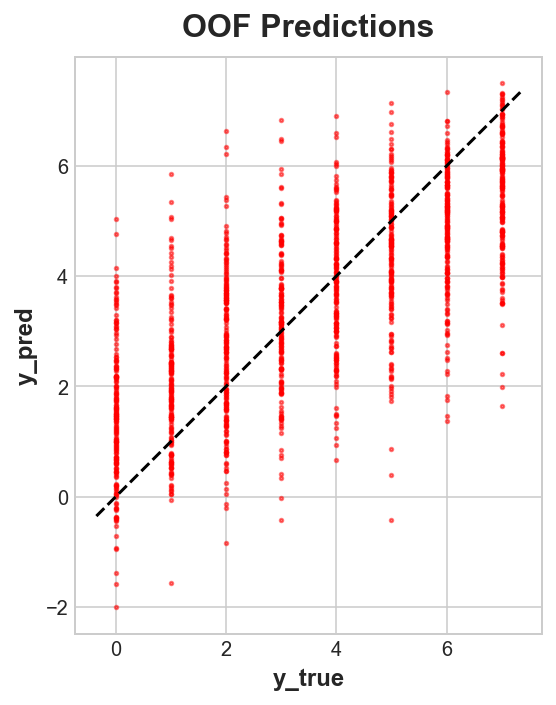

In [103]:
plot_oof(y_test, y_pred)

In [104]:
min(y_pred)

-2.0059745

In [105]:
# Get feature importances
xgb.feature_importances_

array([0.0000000e+00, 0.0000000e+00, 7.5492673e-05, ..., 1.2458678e-03,
       6.4065814e-04, 2.3930522e-03], dtype=float32)

In [106]:
mean_absolute_error(y_test, y_pred)

1.2559338654269085

In [107]:
mean_squared_error(y_test, y_pred)

2.506329392837315